# Implementation of YIN Algorithm

## V For Science Project
- https://youtu.be/W585xR3bjLM
- https://github.com/NValsted/VForScienceProjects/blob/master/YIN_pitch_detection/pitch_detection.py

# Imports and Configs

In [169]:
from scipy.io import wavfile
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from dataclasses import dataclass
import IPython


SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font',size=BIGGER_SIZE)
plt.rc('axes',titlesize=MEDIUM_SIZE)
plt.rc('axes',labelsize=BIGGER_SIZE)
plt.rc('xtick',labelsize=MEDIUM_SIZE)
plt.rc('ytick',labelsize=MEDIUM_SIZE)
plt.rc('legend',fontsize=BIGGER_SIZE-1)
plt.rc('figure',titlesize=BIGGER_SIZE)
plt.rc('axes',axisbelow=True)

In [170]:
import warnings
warnings.filterwarnings("ignore")

# Function Definitions

## V For Science functions

In [171]:
# Autocorrelation Function
def ACF_v4s( f, W, t, lag):
    return np.sum( f[t : t + W] * f[lag + t : lag + t + W] )

# Difference Function (distribution of MSE)
def DF_v4s(f , W, t, lag):
    return ACF_v4s(f, W, t, 0) + ACF_v4s(f, W, t + lag, 0) - (2 * ACF_v4s(f, W, t, lag))

# Cumulative Mean Normalized Difference Function
def CMNDF_v4s(f, W, t , lag):
    if lag == 0:
        return 1
    return DF_v4s(f, W, t, lag) / np.sum([DF_v4s(f, W, t, j+1) for j in range(lag)]) * lag

# Memoized CMNDF
def memo_CMNDF_v4s(f, W, t, lag_max):
    running_sum = 0
    vals = []
    for lag in range(0, lag_max):
        if lag == 0:
            vals.append(1)
            running_sum += 0
        else:
            running_sum += DF_v4s(f, W, t, lag)
            vals.append(DF_v4s(f, W, t, lag) / running_sum * lag)
    return vals

# Detect pitch using CMNDF
def detect_pitch_v4s( f, W, t, sample_rate, bounds, thresh = 0.1):
    CMNDF_vals = [CMNDF_v4s(f, W, t, i) for i in range(*bounds)]
    sample = None
    for i, val in enumerate(CMNDF_vals):
        if val < thresh:
            sample = i + bounds[0]
            break
    if sample is None:
        sample = np.argmin(CMNDF_vals) + bounds[0]


    return sample_rate / sample

# Detect pitch using memoized CMNDF
def detect_pitch_memo_v4s(f, W, t, sample_rate, bounds, thresh=0.1):
    CMNDF_vals = memo_CMNDF_v4s(f, W, t, bounds[-1])[bounds[0]:]
    sample = None
    for i, val in enumerate(CMNDF_vals):
        if val < thresh:
            sample = i + bounds[0]
            break
    if sample is None:
        sample = np.argmin(CMNDF_vals) + bounds[0]
    return sample_rate / (sample + 1)

## Ledesma-Smolkin Functions

In [172]:
# Autocorrelation Function
def ACF_lesm(f, W, t, lag):
    corr = np.correlate(f[t : t + W], f[t + lag : t + lag + W], mode = 'valid')
    return corr[0]

# Difference Function (distribution of MSE)
def DF_lesm(f, W, lag):
    return ACF_lesm(f, W, 0, 0) + ACF_lesm(f, W, lag, 0) - (2 * ACF_lesm(f, W, 0, lag))

# Optimized Algorithm without Parabolic Interpolation or Best Local Estimate
def detect_pitch_lesm(f, W, sample_rate, bounds, thresh=0.1):
    lag_max = bounds[1]
    running_sum = 0
    vals = [1]
    sample = None

    for lag in range(1, lag_max):
        # Difference Function
        dfResult = DF_lesm(f, W, lag)
        # Memoized Cumulative Mean Normalized Difference Function
        running_sum += dfResult
        val = dfResult / running_sum * lag
        vals.append(val)
        # Absolute Thresholding with short-stopping
        if lag >= bounds[0] and val < thresh:
            sample = lag
            break
    # No acceptable lag found, default to minimum error
    else:
        argmin = np.argmin(vals)
        sample = argmin if argmin > bounds[0] else bounds[0]

    return sample_rate / sample

In [173]:
# Data class for processed pitch data
@dataclass(frozen=True)
class PitchData:
    name : str
    sampleRate : int
    srcLen : int
    pitches : np.ndarray

# Import audio file and return sample rate and data
def import_audio(audio_file):
    sample_rate, data = wavfile.read(f'audios/{audio_file}')
    data = data.astype(np.float64)
    IPython.display.display(IPython.display.Audio(f'audios/{audio_file}'))
    return sample_rate, data

# Process audio file with selected method and return PitchData object
def process_audio(data, sample_rate, name=str ,fmin=100, fmax=2000, windows_size_ms=2.5, method='lesm'):

    # Resulting values
    windows_size = int(windows_size_ms/1000 * sample_rate)
    lagMin = int(1/fmax * sample_rate)
    lagMax = int(1/fmin * sample_rate)
    bounds = [ lagMin , lagMax ]

    pitches = []
    
    match method:
        case 'lesm':
            for i in tqdm(range(data.shape[0] // (windows_size+3))):
                t = i*windows_size
                pitches.append(detect_pitch_lesm(f=data[t : t + windows_size + lagMax], W=windows_size, sample_rate=sample_rate, bounds=bounds))
        case 'v4s':
            for i in tqdm(range(data.shape[0] // (windows_size+3))):
                pitches.append(detect_pitch_v4s(f=data, W=windows_size, t=i*windows_size, sample_rate=sample_rate, bounds=bounds))
        case 'memo_v4s':
            for i in tqdm(range(data.shape[0] // (windows_size+3))):
                pitches.append(detect_pitch_memo_v4s(f=data, W=windows_size, t=i*windows_size, sample_rate=sample_rate, bounds=bounds))
        case _:
            raise ValueError(f'Invalid method: {method}')

    return PitchData(name=(name if name is not None else name), sampleRate=sample_rate, srcLen=data.shape[0], pitches=np.array(pitches))


## Plotting functions

In [174]:
# Numpy array of all note frequencies from C0 to B8
noteFrequencies = np.array([16.35,  17.32,  18.35,  19.45,  20.60,  21.83,  23.12,  24.50,  25.96,  27.50,  29.14,  30.87,
                            32.70,  34.65,  36.71,  38.89,  41.20,  43.65,  46.25,  49.00,  51.91,  55.00,  58.27,  61.74,
                            65.41,  69.30,  73.42,  77.78,  82.41, 87.31, 92.50, 98.00, 103.83, 110.00, 116.54, 123.47,
                            130.81, 138.59, 146.83, 155.56, 164.81, 174.61, 185.00, 196.00, 207.65, 220.00, 233.08, 246.94,
                            261.63, 277.18, 293.66, 311.13, 329.63, 349.23, 369.99, 392.00, 415.30, 440.00, 466.16, 493.88,
                            523.25, 554.37, 587.33, 622.25, 659.25, 698.46, 739.99, 783.99, 830.61, 880.00, 932.33, 987.77,
                            1046.50, 1108.73, 1174.66, 1244.51, 1318.51, 1396.91, 1479.98, 1567.98, 1661.22, 1760.00, 1864.66, 1975.53,
                            2093.00, 2217.46, 2349.32, 2489.02, 2637.02, 2793.83, 2959.96, 3135.96, 3322.44, 3520.00, 3729.31, 3951.07,
                            4186.01, 4434.92, 4698.63, 4978.03, 5274.04, 5587.65, 5919.91, 6271.93, 6644.88, 7040.00, 7458.62, 7902.13])

# Numpy array of intermediate frequencies between each note
halfFrequencies = np.array([np.mean([noteFrequencies[i], noteFrequencies[i+1]]) for i in range(len(noteFrequencies)-1)])

# Dictionary of RGB colors for each note, using the same color for each octave
noteColors = {halfFrequencies[i]: plt.cm.tab20(i % 12) for i in range(len(halfFrequencies))}

note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

# Function that plots the note intervals in color using same color for note octaves
def plot_note_intervals(fmin, fmax):
    idmin = np.abs(noteFrequencies - fmin).argmin()
    idmin = idmin - 2 if noteFrequencies[idmin] > fmin else idmin - 1
    idmax = np.abs(noteFrequencies - fmax).argmin()
    idmax = idmax if noteFrequencies[idmax] < fmax else idmax - 1

    for i in range(idmin, idmax):
        plt.axhspan(halfFrequencies[i], halfFrequencies[i+1], color=noteColors[halfFrequencies[i]], alpha=0.2)
        # Show note names in the middle of the interval
        if fmin < noteFrequencies[i+1] < fmax:
            plt.text(0, noteFrequencies[i+1], note_names[(i+1) % 12] + str((i+1) // 12), ha='right', va='center')

def plot_pitches(fmin:int, fmax:int, dataObjects=None):
    if dataObjects is not None:
        plt.figure(figsize=(20,8))
        plt.yscale('log')
        plot_note_intervals(fmin=fmin, fmax=fmax)
        for index, dataObject in enumerate(dataObjects):
            t = np.linspace(0, dataObject.srcLen//dataObject.sampleRate, num = len(dataObject.pitches))
            plt.scatter(t, dataObject.pitches, color=plt.cm.Set1(index % 9), label=dataObject.name, s=10)
        plt.legend()
        plt.ylim(fmin, fmax)
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        plt.show()


def plot_audio_normalized(data,fs,name):
    data = data / np.max(data)
    plt.figure(figsize=(20,8))
    t = np.linspace(0, len(data)//fs, num = len(data))
    plt.plot(t,data,label=name)
    plt.grid()
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

# Audio Processing

## Process all audio with short time detech pitch function

### Singer

In [175]:
audio_file = 'singer.wav'
method = ['lesm', 'v4s', 'memo_v4s']
fs, audio_data = import_audio(audio_file)
singer_pitches = []
for m in method:
    print('Processing audio file: ' + audio_file + ' with method: ' + m + '...')
    singer_pitches.append(process_audio(data = audio_data, sample_rate = fs, name=audio_file+ ' ' +m ,fmin=300, fmax=2000, windows_size_ms=5, method=m))

Processing audio file: singer.wav with method: lesm...


100%|██████████| 479/479 [00:00<00:00, 1043.16it/s]


Processing audio file: singer.wav with method: v4s...


100%|██████████| 479/479 [01:18<00:00,  6.08it/s]


Processing audio file: singer.wav with method: memo_v4s...


100%|██████████| 479/479 [00:02<00:00, 209.66it/s]


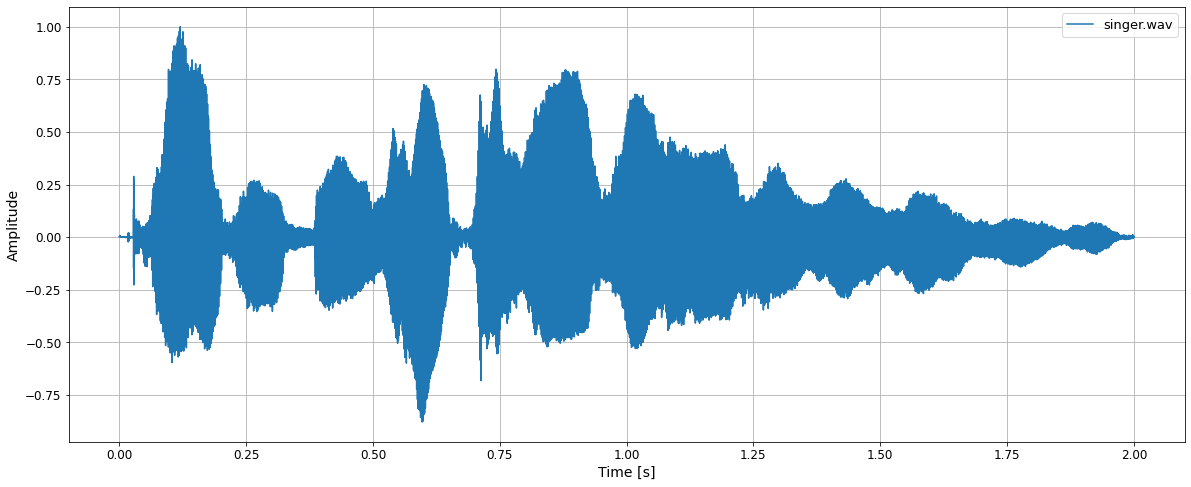

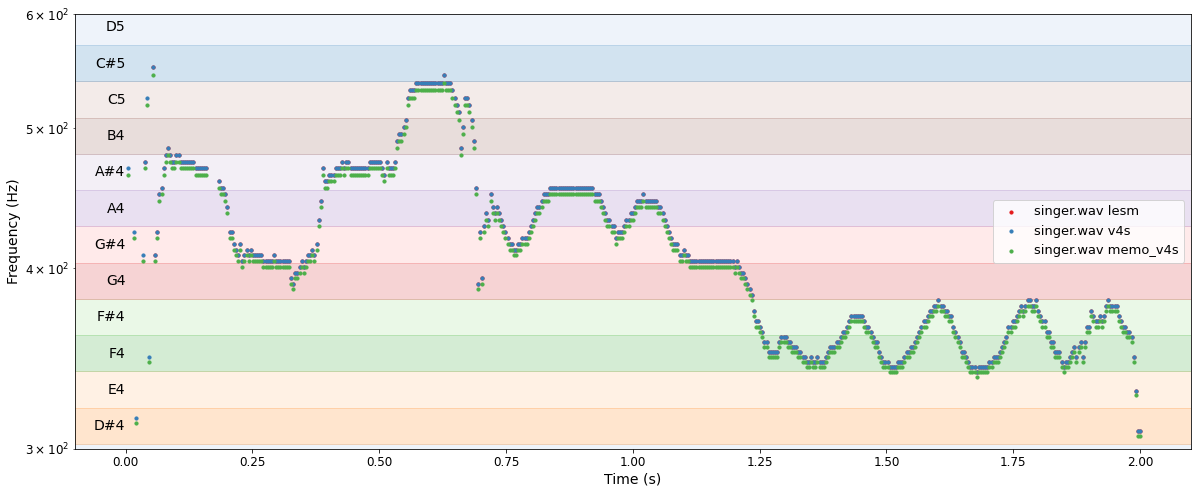

In [176]:
plot_audio_normalized(audio_data, fs, name=audio_file)
plot_pitches(fmin=300, fmax=600, dataObjects=singer_pitches)

### Lidio

In [177]:
audio_file = 'lidio.wav'
method = ['lesm', 'v4s', 'memo_v4s']
fs, audio_data = import_audio(audio_file)
audio_data = audio_data[:,0]
lidio_pitches = []
for m in method:
    print('Processing audio file: ' + audio_file + ' with method: ' + m + '...')
    lidio_pitches.append(process_audio(data = audio_data, sample_rate = fs, name=audio_file+ ' ' +m ,fmin=300, fmax=2000, windows_size_ms=2.5, method=m))

Processing audio file: lidio.wav with method: lesm...


100%|██████████| 1984/1984 [00:00<00:00, 2974.43it/s]


Processing audio file: lidio.wav with method: v4s...


100%|██████████| 1984/1984 [00:41<00:00, 47.83it/s]


Processing audio file: lidio.wav with method: memo_v4s...


100%|██████████| 1984/1984 [00:03<00:00, 618.17it/s]


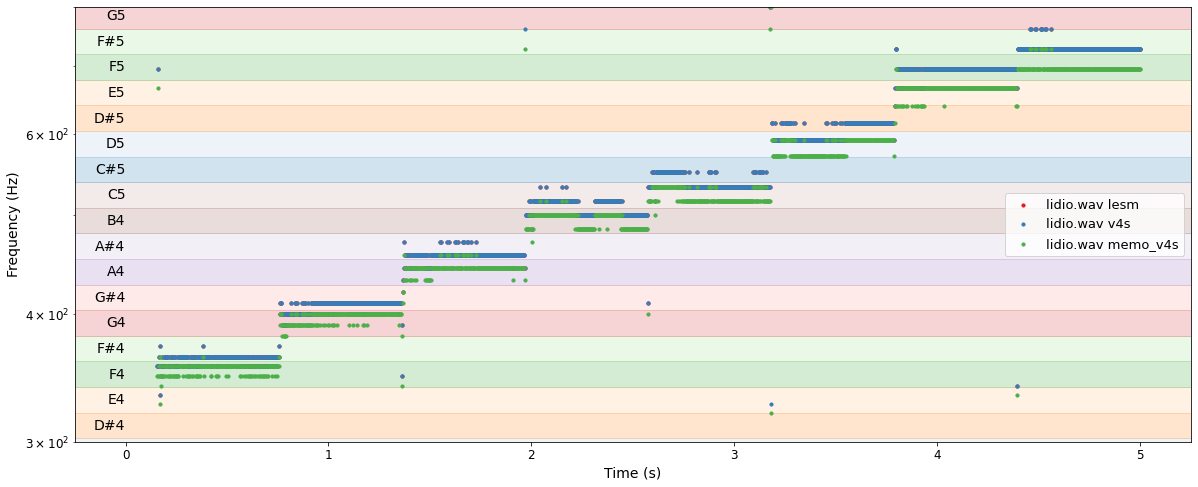

In [178]:
# plot_audio_normalized(audio_data, fs, name=audio_file)
plot_pitches(fmin=300, fmax=800, dataObjects=lidio_pitches)

### lidioa441.wav

In [179]:
audio_file = 'lidioa441.wav'
method = ['lesm', 'memo_v4s']
fs, audio_data = import_audio(audio_file)
lidioa441_pitches = []
for m in method:
    print('Processing audio file: ' + audio_file + ' with method: ' + m + '...')
    lidioa441_pitches.append(process_audio(data = audio_data, sample_rate = fs, name=audio_file+ ' ' +m ,fmin=100, fmax=2000, windows_size_ms=5, method=m))

Processing audio file: lidioa441.wav with method: lesm...


100%|██████████| 969/969 [00:01<00:00, 776.34it/s]


Processing audio file: lidioa441.wav with method: memo_v4s...


100%|██████████| 969/969 [00:14<00:00, 66.50it/s]


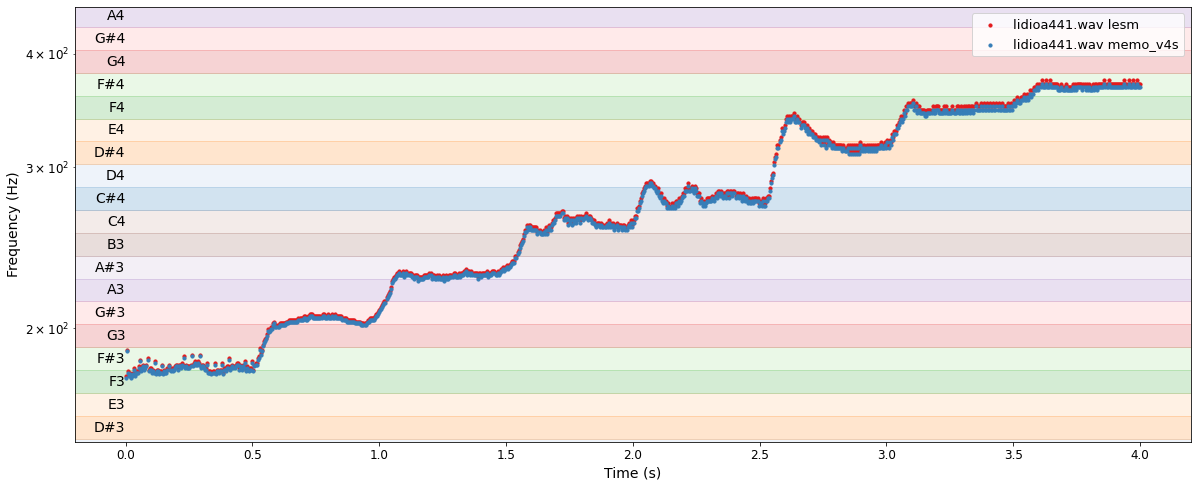

In [180]:
# plot_audio_normalized(audio_data, fs, name=audio_file)
plot_pitches(fmin=150, fmax=450, dataObjects=lidioa441_pitches)

### lidiow441

In [181]:
audio_file = 'lidiow441.wav'
method = ['lesm', 'memo_v4s']
fs, audio_data = import_audio(audio_file)
lidiow441_pitches = []
for m in method:
    print('Processing audio file: ' + audio_file + ' with method: ' + m + '...')
    lidiow441_pitches.append(process_audio(data = audio_data, sample_rate = fs, name=audio_file+ ' ' +m ,fmin=100, fmax=2000, windows_size_ms=5, method=m))

Processing audio file: lidiow441.wav with method: lesm...


100%|██████████| 922/922 [00:00<00:00, 2012.11it/s]


Processing audio file: lidiow441.wav with method: memo_v4s...


100%|██████████| 922/922 [00:13<00:00, 67.64it/s]


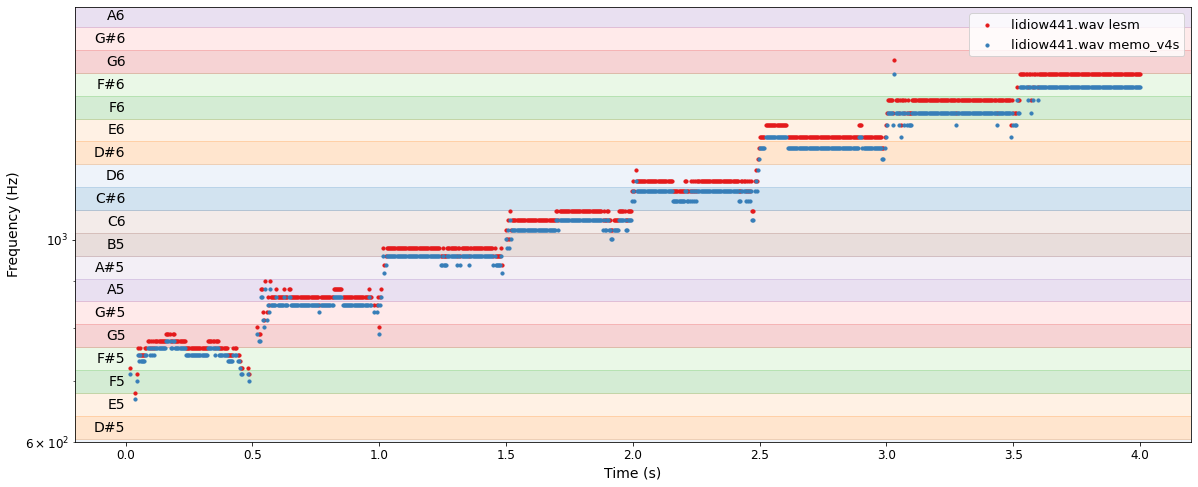

In [182]:
# plot_audio_normalized(audio_data, fs, name=audio_file)
plot_pitches(fmin=600, fmax=1800, dataObjects=lidiow441_pitches)

### flyme441.wav

In [183]:
audio_file = 'flyme441.wav'
method = ['lesm', 'memo_v4s']
fs, audio_data = import_audio(audio_file)
flyme441_pitches = []
for m in method:
    print('Processing audio file: ' + audio_file + ' with method: ' + m + '...')
    flyme441_pitches.append(process_audio(data = audio_data, sample_rate = fs, name=audio_file+ ' ' +m ,fmin=100, fmax=2000, windows_size_ms=5, method=m))

Processing audio file: flyme441.wav with method: lesm...


100%|██████████| 560/560 [00:00<00:00, 684.50it/s]


Processing audio file: flyme441.wav with method: memo_v4s...


100%|██████████| 560/560 [00:08<00:00, 67.67it/s]


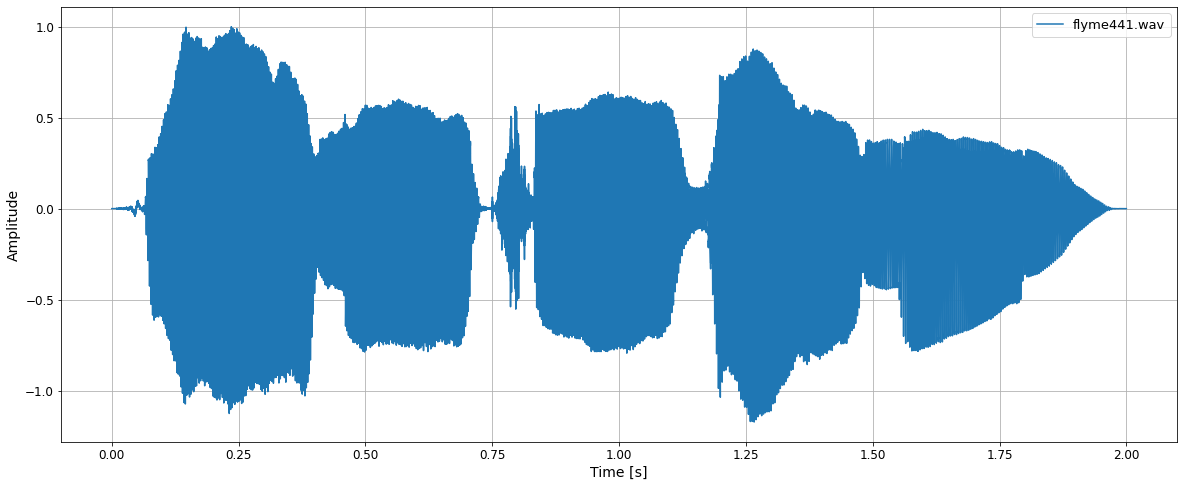

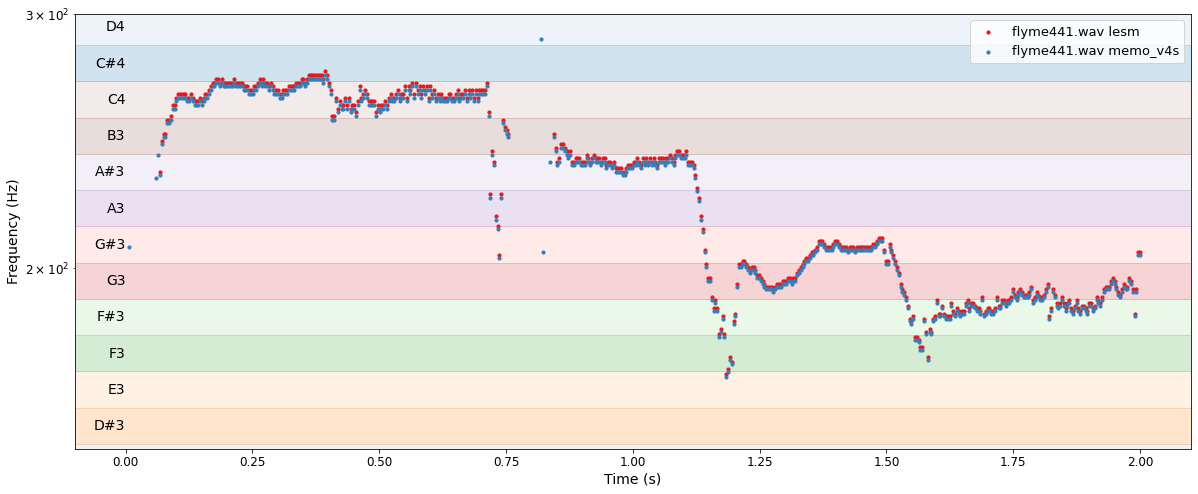

In [184]:
plot_audio_normalized(audio_data, fs, name=audio_file)
plot_pitches(fmin=150, fmax=300, dataObjects=flyme441_pitches)

### flymes441.wav

In [185]:
audio_file = 'flymes441.wav'
method = ['lesm', 'memo_v4s']
fs, audio_data = import_audio(audio_file)
flymes441_pitches = []
for m in method:
    print('Processing audio file: ' + audio_file + ' with method: ' + m + '...')
    flymes441_pitches.append(process_audio(data = audio_data, sample_rate = fs, name=audio_file+ ' ' +m ,fmin=100, fmax=2000, windows_size_ms=5, method=m))

Processing audio file: flymes441.wav with method: lesm...


100%|██████████| 573/573 [00:00<00:00, 623.38it/s]


Processing audio file: flymes441.wav with method: memo_v4s...


100%|██████████| 573/573 [00:08<00:00, 68.56it/s]


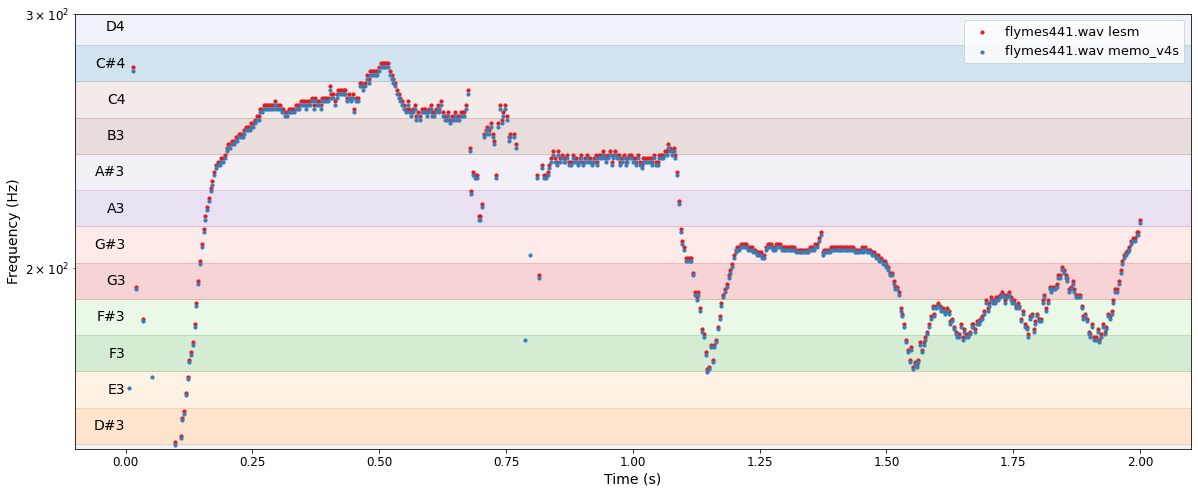

In [186]:
# plot_audio_normalized(audio_data, fs, name=audio_file)
plot_pitches(fmin=150, fmax=300, dataObjects=flymes441_pitches)

### Sweep windows size

100%|██████████| 947/947 [00:00<00:00, 1272.44it/s]


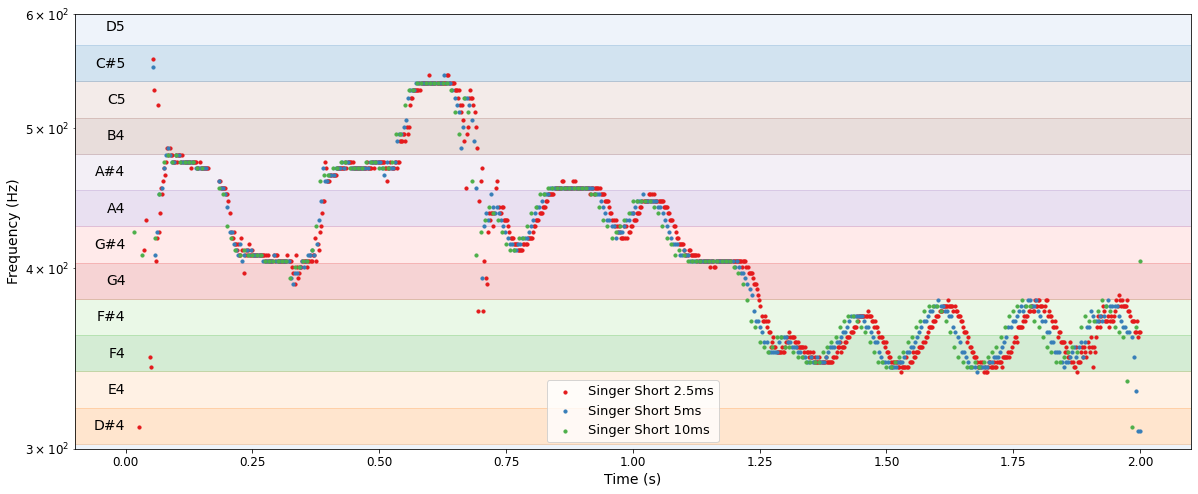

In [190]:
audio_file = 'singer.wav'
method = ['lesm']
fs, audio_data = import_audio(audio_file)
singerShortPitches_w10 = process_audio(audio_data,fs, name = 'Singer Short 10ms', fmin=200, fmax=2000, windows_size_ms=10)
singerShortPitches_w5 = process_audio(audio_data,fs, name = 'Singer Short 5ms', fmin=200, fmax=2000, windows_size_ms=5)
singerShortPitches_w2_5 = process_audio(audio_data,fs, name = 'Singer Short 2.5ms', fmin=200, fmax=2000, windows_size_ms=2.5)
plot_pitches(fmin=300, fmax=600, dataObjects=[singerShortPitches_w2_5,singerShortPitches_w5,singerShortPitches_w10])